# For cross attention and Unet investigation

In [208]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/Colab Notebooks/ECE1508/Project/dataset.zip" -d /content/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/dataset/abstract_monochrome_patterned_outerwear_coat.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/dataset/__MACOSX/._abstract_monochrome_patterned_outerwear_coat.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [211]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer, BertConfig
import os
import matplotlib.pyplot as plt
import math

In [212]:
# assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"currently running on {device}")

currently running on cuda


# BERT Class

In [ ]:
# Dataset Class
class FashionCaptionDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2. - 1.) # map to [-1,1] for centered training
        ])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Extract caption from filename
        caption = self.image_files[idx].replace('.png', '')
        caption = caption.replace('_', ' ').replace('.', ' ')
        caption = ' '.join(caption.split())  # Clean extra spaces

        return self.transform(image), caption

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.proj = nn.Linear(768, 128)  # Project to smaller dimension

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, captions):
        inputs = self.tokenizer(
            captions,
            padding=True,
            truncation=True,
            max_length=32,
            return_tensors="pt"
        ).to(device)

        outputs = self.bert(**inputs)
        pooled = outputs.last_hidden_state  
        return self.proj(pooled)

In [214]:
# something is not right

#ds = FashionCaptionDataset('/content/drive/MyDrive/Colab Notebooks/ECE1508/Project/mini_dataset')
ds = FashionCaptionDataset('/content/dataset')
print(len(ds))
test_size = int(0.2 * len(ds))
train_size = len(ds) - test_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=6, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=6, shuffle=False)

96


(5, 10, 128)


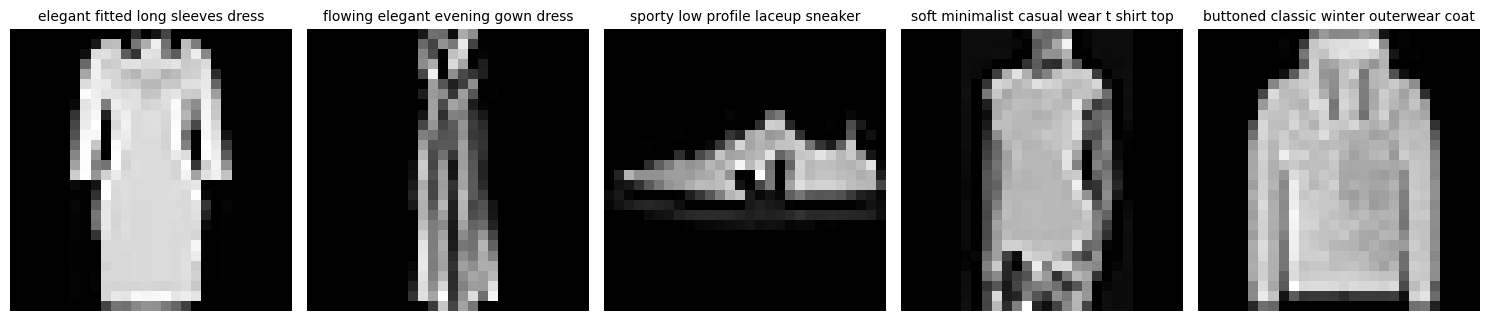


Caption 1: elegant fitted long sleeves dress
Embedding shape: (10, 128)

Caption 2: flowing elegant evening gown dress
Embedding shape: (10, 128)

Caption 3: sporty low profile laceup sneaker
Embedding shape: (10, 128)

Caption 4: soft minimalist casual wear t shirt top
Embedding shape: (10, 128)

Caption 5: buttoned classic winter outerwear coat
Embedding shape: (10, 128)


In [215]:
# Get one batch
x_batch, y_batch = next(iter(train_loader))  # x: [B, 1, 28, 28], y: list of captions
x_batch = x_batch[:5]  # select first 5 samples
y_batch = y_batch[:5]  # corresponding captions

# Send to device and encode
x_batch = x_batch.to(device)
text_encoder = TextEncoder().to(device)


with torch.no_grad():
    text_embeddings = text_encoder(y_batch).cpu().numpy()  # shape: [5, N, 128]
    print(text_embeddings.shape)
# Plot images and print embeddings
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow((x_batch[i].cpu().squeeze() + 1) / 2, cmap='gray')  # inverse normalize
    axs[i].axis('off')
    axs[i].set_title(f"{y_batch[i]}", fontsize=10)

plt.tight_layout()
plt.show()

# Show text embedding summaries
for i in range(5):
    print(f"\nCaption {i+1}: {y_batch[i]}")
    print(f"Embedding shape: {text_embeddings[i].shape}")
    # print(f"Embedding values: {text_embeddings[i][:]}")

# Converting images from pixels to Patches

In [216]:
def convert_image_to_patches(image, patch_size = 4):
  B, ch, weight, height = image.shape

  patch = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
  print(patch.shape)
  patch = patch.permute(0, 2, 3, 1, 4, 5) # [B, patch_height, patch_width, ch, patch_size, patch_size]
  print(patch.shape)
  patch = patch.contiguous().view(B, -1, ch * patch_size * patch_size) # [B, patch_number, patch_size ** 2]
  return patch


print(x_batch.shape)
image_patch = convert_image_to_patches(x_batch, 4)

torch.Size([5, 1, 28, 28])
torch.Size([5, 1, 7, 7, 4, 4])
torch.Size([5, 7, 7, 1, 4, 4])


# Cross Attention between text and image in embedding space

In [217]:
# Text to image cross attention between text to image
class CrossAttention(nn.Module):
  def __init__(self, dim_q, dim_k_v, head=4, dim_head=32, bias_setting=False):
    """
    dim_q: dimension of query --> here should be the embedding size of image features
    dim_k_v: dimension of key and value --> shoube the embedding size of text features
    head: number of heads
    dim_head: dimension of each head
    bias_setting: whether to use bias in the linear layers
    """
    super(CrossAttention, self).__init__()
    self.head = head
    self.dim_head = dim_head
    self.scale = self.dim_head ** -0.5


    self.q = nn.Linear(dim_q, self.dim_head * head, bias=bias_setting)
    self.k = nn.Linear(dim_k_v, self.dim_head * head, bias=bias_setting)
    self.v = nn.Linear(dim_k_v, self.dim_head * head, bias=bias_setting)
    self.out = nn.Linear(self.dim_head * head, dim_q)

  def forward(self, image_query, text_context):
    """
    image_query: used for the image [BS, N_query, dim_q]
    text_context: used for the text [BS, N_context, dim_k_v]
    for all N_query and N_context: N the number of tokens in the sequence
    for image: for a patch of 16 * 16 --> (256 / 16) * (256 / 16) = 256 --> basically to prevent image token to be too long
    """
    BS = image_query.shape[0]
    N_query = image_query.shape[1]
    N_context = text_context.shape[1]

    # for multi head
    # [B, heads, Nq, dim_q]
    q = self.q(image_query)
    q = q.view(BS, N_query, self.head, self.dim_head).transpose(1, 2)

    k = self.k(text_context)
    k = k.view(BS, N_context, self.head, self.dim_head).transpose(1, 2)

    v = self.v(text_context)
    v = v.view(BS, N_context, self.head, self.dim_head).transpose(1, 2)

    # compute attention
    score = torch.matmul(q, k.transpose(-1, -2)) * self.scale
    weights = F.softmax(score, dim=-1)
    output = torch.matmul(weights, v)

    output = output.transpose(1, 2)
    return self.out(output.reshape(BS, N_query, -1)) #[B, N_image, patch_size ** 2]



In [218]:
# some testing coding
# Simulate image tokens
B, N_img, dim_img = 2, 49 + 1, 4 * 4
image_tokens = torch.randn(B, N_img, dim_img)

# Simulate text tokens
N_text, dim_text = 32, 768
text_tokens = torch.randn(B, N_text, dim_text)

# Instantiate and test
attn = CrossAttention(dim_q=16, dim_k_v=768, head=4)
out = attn(image_tokens, text_tokens)  # [B, 256, 512]
print(out.shape)

torch.Size([2, 50, 16])


# Self-attention on the pixels

In [219]:
class ImageSelfAttention(nn.Module):
  def __init__(self, dim, heads=8, dim_head=64, bias_setting=False):
    super(ImageSelfAttention, self).__init__()
    self.head = heads
    self.scale = dim_head ** -0.5

    self.q = nn.Linear(dim, dim_head * heads, bias=bias_setting)
    self.k = nn.Linear(dim, dim_head * heads, bias=bias_setting)
    self.v = nn.Linear(dim, dim_head * heads, bias=bias_setting)
    self.out = nn.Linear(dim_head * heads, dim)

  def forward(self, x):
    """
    x: [B, N, dim]
    """
    BS = x.shape[0]
    N = x.shape[1]

    q = self.q(x)
    q = q.view(BS, N, self.head, -1).transpose(1, 2)

    k = self.k(x)
    k = k.view(BS, N, self.head, -1).transpose(1, 2)

    v = self.v(x)
    v = v.view(BS, N, self.head, -1).transpose(1, 2)

    # compute self attention
    score = torch.matmul(q, k.transpose(-1, -2)) * self.scale
    weights = F.softmax(score, dim=-1)
    output = torch.matmul(weights, v)

    output = output.transpose(1, 2)
    return self.out(output.reshape(BS, N, -1))


In [220]:
B, N, dim = 2, 256, 28*28
image_token = torch.randn(B, N, dim)
self_attn = ImageSelfAttention(dim=dim, heads=8, dim_head=64)
out = self_attn(image_token)
print(out)

tensor([[[-0.0631,  0.0416,  0.0645,  ..., -0.0317, -0.0003,  0.0143],
         [-0.0572,  0.0439,  0.0620,  ..., -0.0231, -0.0113,  0.0109],
         [-0.0512,  0.0501,  0.0491,  ..., -0.0189, -0.0022,  0.0197],
         ...,
         [-0.0688,  0.0464,  0.0680,  ..., -0.0235,  0.0018,  0.0095],
         [-0.0505,  0.0315,  0.0729,  ..., -0.0195,  0.0088,  0.0083],
         [-0.0560,  0.0207,  0.0618,  ..., -0.0207,  0.0045,  0.0255]],

        [[-0.0090,  0.0385,  0.0403,  ...,  0.0156, -0.0069,  0.0247],
         [ 0.0063,  0.0422,  0.0421,  ...,  0.0139, -0.0036,  0.0252],
         [ 0.0148,  0.0384,  0.0651,  ...,  0.0241, -0.0100,  0.0299],
         ...,
         [ 0.0060,  0.0385,  0.0468,  ...,  0.0146, -0.0087,  0.0166],
         [ 0.0075,  0.0569,  0.0534,  ..., -0.0046, -0.0024,  0.0375],
         [ 0.0124,  0.0315,  0.0376,  ...,  0.0022,  0.0067,  0.0325]]],
       grad_fn=<ViewBackward0>)


# Attention_block

https://arxiv.org/pdf/2112.10752

In [221]:
# class SelfCrossAttentionBlock(nn.Module):
#   def __init__(self, dim_q, dim_k_v, heads, dim_head, bias_setting = False, linear_scale = 2, dropout = 0.0):
#     super(SelfCrossAttentionBlock, self).__init__()
#     self.cross_attention = CrossAttention(dim_q, dim_k_v, heads, dim_head, bias_setting)
#     self.image_self_attention = ImageSelfAttention(dim_q, heads, dim_head, bias_setting)
#     self.dropout = nn.Dropout(dropout)

#     self.layer_norm_1 = nn.LayerNorm(dim_q)
#     self.layer_norm_2 = nn.LayerNorm(dim_q)
#     self.layer_norm_3 = nn.LayerNorm(dim_q)

#     self.mlp = nn.Sequential(
#         nn.Linear(dim_q, dim_q * linear_scale),
#         nn.GELU(),
#         nn.Dropout(dropout),
#         nn.Linear(dim_q * linear_scale, dim_q)
#     )

#   def forward(self, image, text):
#     if image.ndim == 4:
#         B, C, H, W = image.shape
#         image = image.view(B, C, H * W) # [B, H*W, C]
#     elif image.ndim == 3:
#         B, N, D = image.shape
#         dim_q = N

#     # image = image + self.image_self_attention(self.layer_norm_1(image)) // Omit for now
#     image = image + self.cross_attention(self.layer_norm_2(image), text)
#     image = image + self.mlp(self.layer_norm_3(image))

#     return image


In [222]:
class CrossAttentionBlock(nn.Module):
  def __init__(self, dim_q, dim_k_v, head=4, dim_head=32, linear_scale=2, bias_settings=False, dropout=0.0):
    super(CrossAttentionBlock, self).__init__()
    self.dim_q = dim_q
    self.dim_k_v = dim_k_v
    self.head = head
    self.dim_head = dim_head
    self.time_embedding = time_embedding
    self.time_embedding = self.time_embedding.to(device)

    # layer norms
    self.layer_norm_attn = nn.LayerNorm(dim_q)
    self.layer_norm_mlp = nn.LayerNorm(dim_q)

    # self attention on images
    # for now ignore

    # MLP
    self.mlp = nn.Sequential(
        nn.Linear(dim_q, dim_q * linear_scale),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(dim_q * linear_scale, dim_q)
    )

    # cross attention
    self.cross_attn = CrossAttention(dim_q, dim_k_v, head, dim_head, bias_settings)

  def forward(self, image, text, timestamp):
    # code begins below
    image = image + timestamp
    image = self.layer_norm_attn(image)
    image = image + self.cross_attn(image, text)
    image = self.layer_norm_mlp(image)
    image = image + self.mlp(image)

    return image




In [223]:
# Image tokens
image_tokens = torch.randn(4, 49, 28*28)  # e.g. 16x16 patches → N=256, dim=512

# Text tokens
text_embeddings = torch.randn(4, 32, 768)  # e.g. from T5 or CLIP

# time embedding
time_embedding = torch.randn(4, 1, 28*28)

block = CrossAttentionBlock(dim_q = 28 * 28, dim_k_v=768,  head=8, dim_head=64)
out = block(image_tokens, text_embeddings, time_embedding)
print(out.shape)


torch.Size([4, 49, 784])


In [224]:
def cal_conv2d_shape(width, kernel_size, stride, padding):
    new_width = (width - kernel_size + 2 * padding) // stride + 1
    new_height = new_width
    return new_width, new_height

def transpose_conv2d_output_shape(input_size, kernel_size, stride, padding, output_padding=0):
    new_weight = (input_size - 1) * stride - 2 * padding + kernel_size + output_padding
    new_height = new_weight
    return new_weight, new_height

# Unet V1

In [225]:
class UNet(nn.Module):
  def __init__(self, channel, time_dim, cnn_params, trans_cnn_params, attn_params, bias_settings=False, linear_scale=2, dropout=0.0):
    super(UNet, self).__init__()
    self.channel = channel
    self.bias_settings = bias_settings
    self.linear_scale = linear_scale
    self.dropout = dropout
    self.time_dim = time_dim

    self.relu = nn.ReLU()

    # ----- Encoder Convs -----
    self.conv1 = nn.Conv2d(channel,
                           cnn_params['inter_layer_channel'],
                           cnn_params['kernel_size_1'],
                           cnn_params['stride_1'],
                           cnn_params['padding_1'],
                           bias=bias_settings)

    self.conv2 = nn.Conv2d(cnn_params['inter_layer_channel'],
                           cnn_params['inter_layer_channel_2'],
                           cnn_params['kernel_size_2'],
                           cnn_params['stride_2'],
                           cnn_params['padding_2'],
                           bias=bias_settings)

    # ----- Decoder Transpose Convs -----
    self.deconv1 = nn.ConvTranspose2d(cnn_params['inter_layer_channel_2'],
                                      trans_cnn_params['inter_layer_channel_1'],
                                      trans_cnn_params['kernel_size_trans_1'],
                                      trans_cnn_params['stride_trans_1'],
                                      trans_cnn_params['padding_trans_1'],
                                      trans_cnn_params['output_padding_trans_1'],
                                      bias=bias_settings)

    self.deconv2 = nn.ConvTranspose2d(trans_cnn_params['inter_layer_channel_1'],
                                      channel,
                                      trans_cnn_params['kernel_size_trans_2'],
                                      trans_cnn_params['stride_trans_2'],
                                      trans_cnn_params['padding_trans_2'],
                                      trans_cnn_params['output_padding_trans_2'],
                                      bias=bias_settings)


    # -------- attn (bottleneck) --------
    self.bn_layer_norm = nn.LayerNorm(cnn_params['inter_layer_channel_2'])

    self.attn_dim_q = attn_params['dim_q']
    self.attn_dim_k_v = attn_params['dim_k_v']
    self.attn_dim_timestamp = attn_params['dim_timestamp']
    self.attn_head = attn_params['head']
    self.attn_dim_head = attn_params['dim_head']
    self.T = attn_params['T'] # this is the number of stacked attention blocks

    # attention blocks according to T
    self.attn_blocks = nn.ModuleList([
        CrossAttentionBlock(
            dim_q = self.attn_dim_head * self.attn_head,
            dim_k_v=self.attn_dim_k_v,
            head=self.attn_head,
            dim_head=self.attn_dim_head
        )
        for _ in range(self.T)
    ])


    # ------- time projections -------

    self.time_proj = nn.Sequential(
        nn.Linear(self.time_dim, self.channel),
        nn.SiLU(),
    )

    self.time_proj_2 = nn.Sequential(
        nn.Linear(cnn_params["inter_layer_channel_2"], linear_scale * cnn_params["inter_layer_channel_2"]),
        nn.SiLU(),
        nn.Linear(linear_scale * cnn_params["inter_layer_channel_2"], self.attn_dim_head * self.attn_head)
    )

    # -------- 1x1 conv ---------
    self.to_bottleneck_conv = nn.Conv2d(cnn_params["inter_layer_channel_2"], self.attn_head * self.attn_dim_head, kernel_size=1, bias=self.bias_settings)
    self.leave_bottleneck_conv = nn.Conv2d(self.attn_head * self.attn_dim_head, cnn_params["inter_layer_channel_2"], kernel_size=1, bias=self.bias_settings)

  def sinusoidal_positional_embedding(self, t, dim):
    denominator = torch.pow(10000, torch.arange(0, dim, 2).float().to(t.device) / dim)
    val = t.float().unsqueeze(-1) / denominator  # (B, dim/2)
    positional_embedding = torch.cat([torch.sin(val), torch.cos(val)], dim=-1)  # (B, dim)
    return positional_embedding # [B, dim]


  def encoder(self, image):
    # skip connections for Unet architecture
    skip_connections = []

    image = self.conv1(image)
    image = self.relu(image)
    skip_connections.append(image)



    image = self.conv2(image)
    image = self.relu(image)
    skip_connections.append(image)
    return image, skip_connections

  def decoder(self, image, skip_connections):
    image = self.deconv1(image + skip_connections[1])
    image = self.relu(image)
    image = self.deconv2(image + skip_connections[0])
    return image


  def forward(self, image, text, timestamp):
    # handle timestamp positional embedding
    time_embedding = self.sinusoidal_positional_embedding(timestamp, self.time_dim)
    time_embedding = self.time_proj(time_embedding)

    B, C = time_embedding.shape
    time_embedding = time_embedding.view(B, C, 1, 1)
    image = image + time_embedding

    # handle encoding path of the Unet
    image, skip_connections = self.encoder(image)
    # handle bottleneck cross attention
    """
    Here is quite complicated and it is strongly recommended to read stable diffusion's paper
    https://arxiv.org/pdf/2112.10752.pdf at page 26
    For our model, we made a lot, i meant a lot of simplifications due to limited resources

    In the original architecture, attention (cross attention is applied in encoder and decoder as well)
    For simplicity, we are putting cross attention in the bottleneck, also we ignored the conv layers in the bottleneck as well
    """
    B, C, H, W = image.shape
    image = image.view(B, H, W, C)
    image = self.bn_layer_norm(image)
    image = image.view(B, C, H, W)

    # conv2d 1x1
    image = self.to_bottleneck_conv(image)

    image = image.view(B, H*W, self.attn_head * self.attn_dim_head) # [B, N_image, image_embedding]

    attn_time_embedding = self.sinusoidal_positional_embedding(timestamp, self.attn_dim_timestamp)
    attn_time_embedding = self.time_proj_2(attn_time_embedding)
    attn_time_embedding = attn_time_embedding.unsqueeze(1)

    for block in self.attn_blocks:
      image = block(image, text, attn_time_embedding)

    image = image.view(B, self.attn_head * self.attn_dim_head, H, W)

    # conv2d 1x1
    image = self.leave_bottleneck_conv(image)
    image = image.view(B, C, H, W)

    # handle decoding path of the Unet
    image = self.decoder(image, skip_connections)

    return image


In [268]:
# these are just dummy variables for testing only

cnn_params = {
    'kernel_size_1': 3,
    'stride_1': 2,
    'padding_1': 1,
    'kernel_size_2': 3,
    'stride_2': 2,
    'padding_2': 1,
    'inter_layer_channel': 32,
    'inter_layer_channel_2': 64
}

trans_cnn_params = {
    'kernel_size_trans_1': 3,
    'stride_trans_1': 2,
    'padding_trans_1': 1,
    'output_padding_trans_1': 1,
    'kernel_size_trans_2': 3,
    'stride_trans_2': 2,
    'padding_trans_2': 1,
    'output_padding_trans_2': 1,
    'inter_layer_channel_1': 32
}

attn_params = {
    'dim_q': 64,             # same as encoder output channel
    'dim_k_v': 128,           # e.g., text embedding dim
    'dim_timestamp': 64,     # should match `time_dim`
    'head': 4,
    'dim_head': 16,
    'T': 2                   # number of cross-attention blocks
}


# Input image tensor: B x C x H x W
image = torch.randn(4, 1, 28, 28)  # (B=4, C=3, H=W=64)
image = image.to(device)

# Text context
text = torch.randn(4, 16, 128)  # (B=4, N_text=16, dim_k_v=256)
text = text.to(device)

# Timestamp input (e.g., diffusion timestep or sequence index)
timestamp = torch.tensor([10, 20, 30, 40])  # (B=4,)
timestamp = timestamp.to(device)

model = UNet(
    channel=1,
    time_dim=64,
    cnn_params=cnn_params,
    trans_cnn_params=trans_cnn_params,
    attn_params=attn_params,
    bias_settings=False
)

model = model.to(device)

In [269]:
output = model(image, text, timestamp)
print(output.shape)

torch.Size([4, 1, 28, 28])


# training

In [270]:
T = 1000  # total diffusion steps
beta = torch.linspace(1e-4, 0.02, T).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # cumulative product
# model instantiate above
#text_encoder = TextEncoder().to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(text_encoder.parameters()), lr=1e-3)

epochs = 250
for epoch in range(epochs):
    pbar = tqdm(train_loader)
    pbar.set_description(f"Epoch {epoch + 1} / {epochs}")
    for x, y in pbar:
        x = x.to(device)  # shape: [B, 1, 28, 28]

        t = torch.randint(0, T, (x.size(0),), device=device)  # random timestep per sample
        alpha_t = alpha_bar[t][:, None, None, None]  # shape: [B, 1, 1, 1]
        # print(alpha_t)
        noise = torch.randn_like(x)
        x_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise

        text_embed = text_encoder(y)

        pred_noise = model(x_t, text_embed, t)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 250 / 250: 100%|██████████| 13/13 [00:00<00:00, 51.46it/s]


In [ ]:
@torch.no_grad()
def sample(description, model, text_encoder,seed=42,  img_size=28, T=1000):
    model.eval()
    text_encoder.eval()

    gen = torch.Generator(device=device)
    gen.manual_seed(seed)

    text_embed = text_encoder([description])

    x = torch.randn(1, 1, img_size, img_size, device=device, generator=gen)

    eps = 1e-5 

    for t in reversed(range(T)):
        t_batch = torch.tensor([t], device=device)

        pred_noise = model(x, text_embed, t_batch)
        pred_noise = pred_noise.clamp(-1.5, 1.5)

        alpha_t = torch.clamp(alpha[t], min=eps)
        alpha_bar_t = torch.clamp(alpha_bar[t], min=eps)

        # DDPM denoising step (deterministic, simplified)
        x = (x - ((1 - alpha_t).sqrt() * pred_noise / alpha_bar_t.sqrt())) / alpha_t.sqrt()

        if torch.isnan(x).any():
            print(f"NaN detected at timestep {t}")
            break

    return x

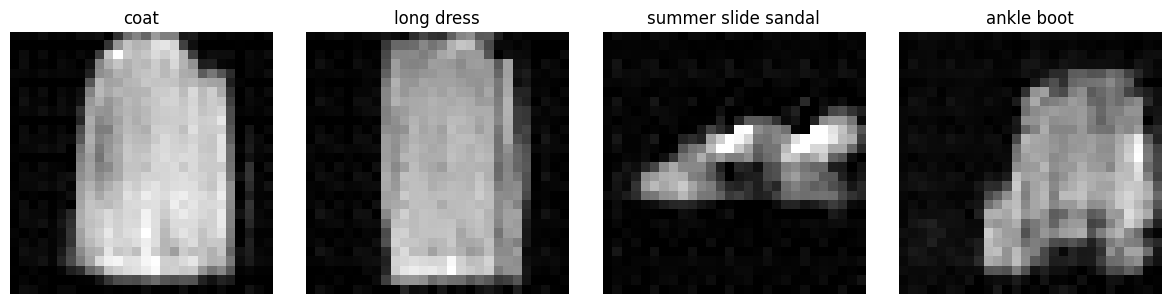

In [273]:
import matplotlib.pyplot as plt

img1 = sample("classic summer outerwear coat", model, text_encoder)
img2 = sample("formal fashion long dress", model, text_encoder)
img3 = sample("open toe strappy summer slide sandal", model, text_encoder)
img4 = sample("texttured high heel modern style ankleboot", model, text_encoder)


plt.figure(figsize=(12, 3))

images = [img1, img2, img3, img4]
titles = ["coat", "long dress", "summer slide sandal", "ankle boot"]

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow((images[i].squeeze().cpu().clamp(-1, 1) + 1) / 2, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()
